In [ ]:
# (i) Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, Binarizer
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.base import clone

In [ ]:
# (ii) Import dataset
df = pd.read_csv('breast_cancer_wisconsin_diagnostic.csv')
target = 'Diagnosis'

In [ ]:
# (iii) EDA and Preprocessing

def is_normal(series):
    skew = series.skew()
    return -0.5 <= skew <= 0.5

def has_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))).sum()
    return outliers > 0

In [ ]:
# Separate types
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if target in categorical_cols:
    categorical_cols.remove(target)
numerical_cols = [col for col in numerical_cols if col != target]

# --- Missing Values Handling ---
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if col in numerical_cols:
            if is_normal(df[col]):
                if has_outliers(df[col]):
                    df[col].fillna(df[col].median(), inplace=True)
                else:
                    df[col].fillna(df[col].mean(), inplace=True)
            else:
                df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)  # categorical

# --- Outlier Replacing (for numerical columns only) ---
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    if is_normal(df[col]):
        replacement_value = df[col].mean()
    else:
        replacement_value = df[col].median()

    # Replace outliers
    df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), replacement_value, df[col])

In [ ]:
# --- Drop rows where target is missing ---
df.dropna(subset=[target], inplace=True)

# --- Feature Engineering (if needed) ---
df["circularity1"] = 4 * np.pi * df["area1"] / (df["perimeter1"] ** 2 + 1e-6)
df["area_per_radius1"] = df["area1"] / (df["radius1"] + 1e-6)

In [ ]:
# --- Encoding categorical features ---
is_classification = True

if is_classification:
    le = LabelEncoder()
    df[target] = le.fit_transform(df[target])  # encode target
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])  # label encoding for classification
else:
    # Regression: target guided ordinal encoding
    for col in categorical_cols:
        ordered_labels = df.groupby(col)[target].mean().sort_values().index
        mapping = {k: i for i, k in enumerate(ordered_labels)}
        df[col] = df[col].map(mapping)

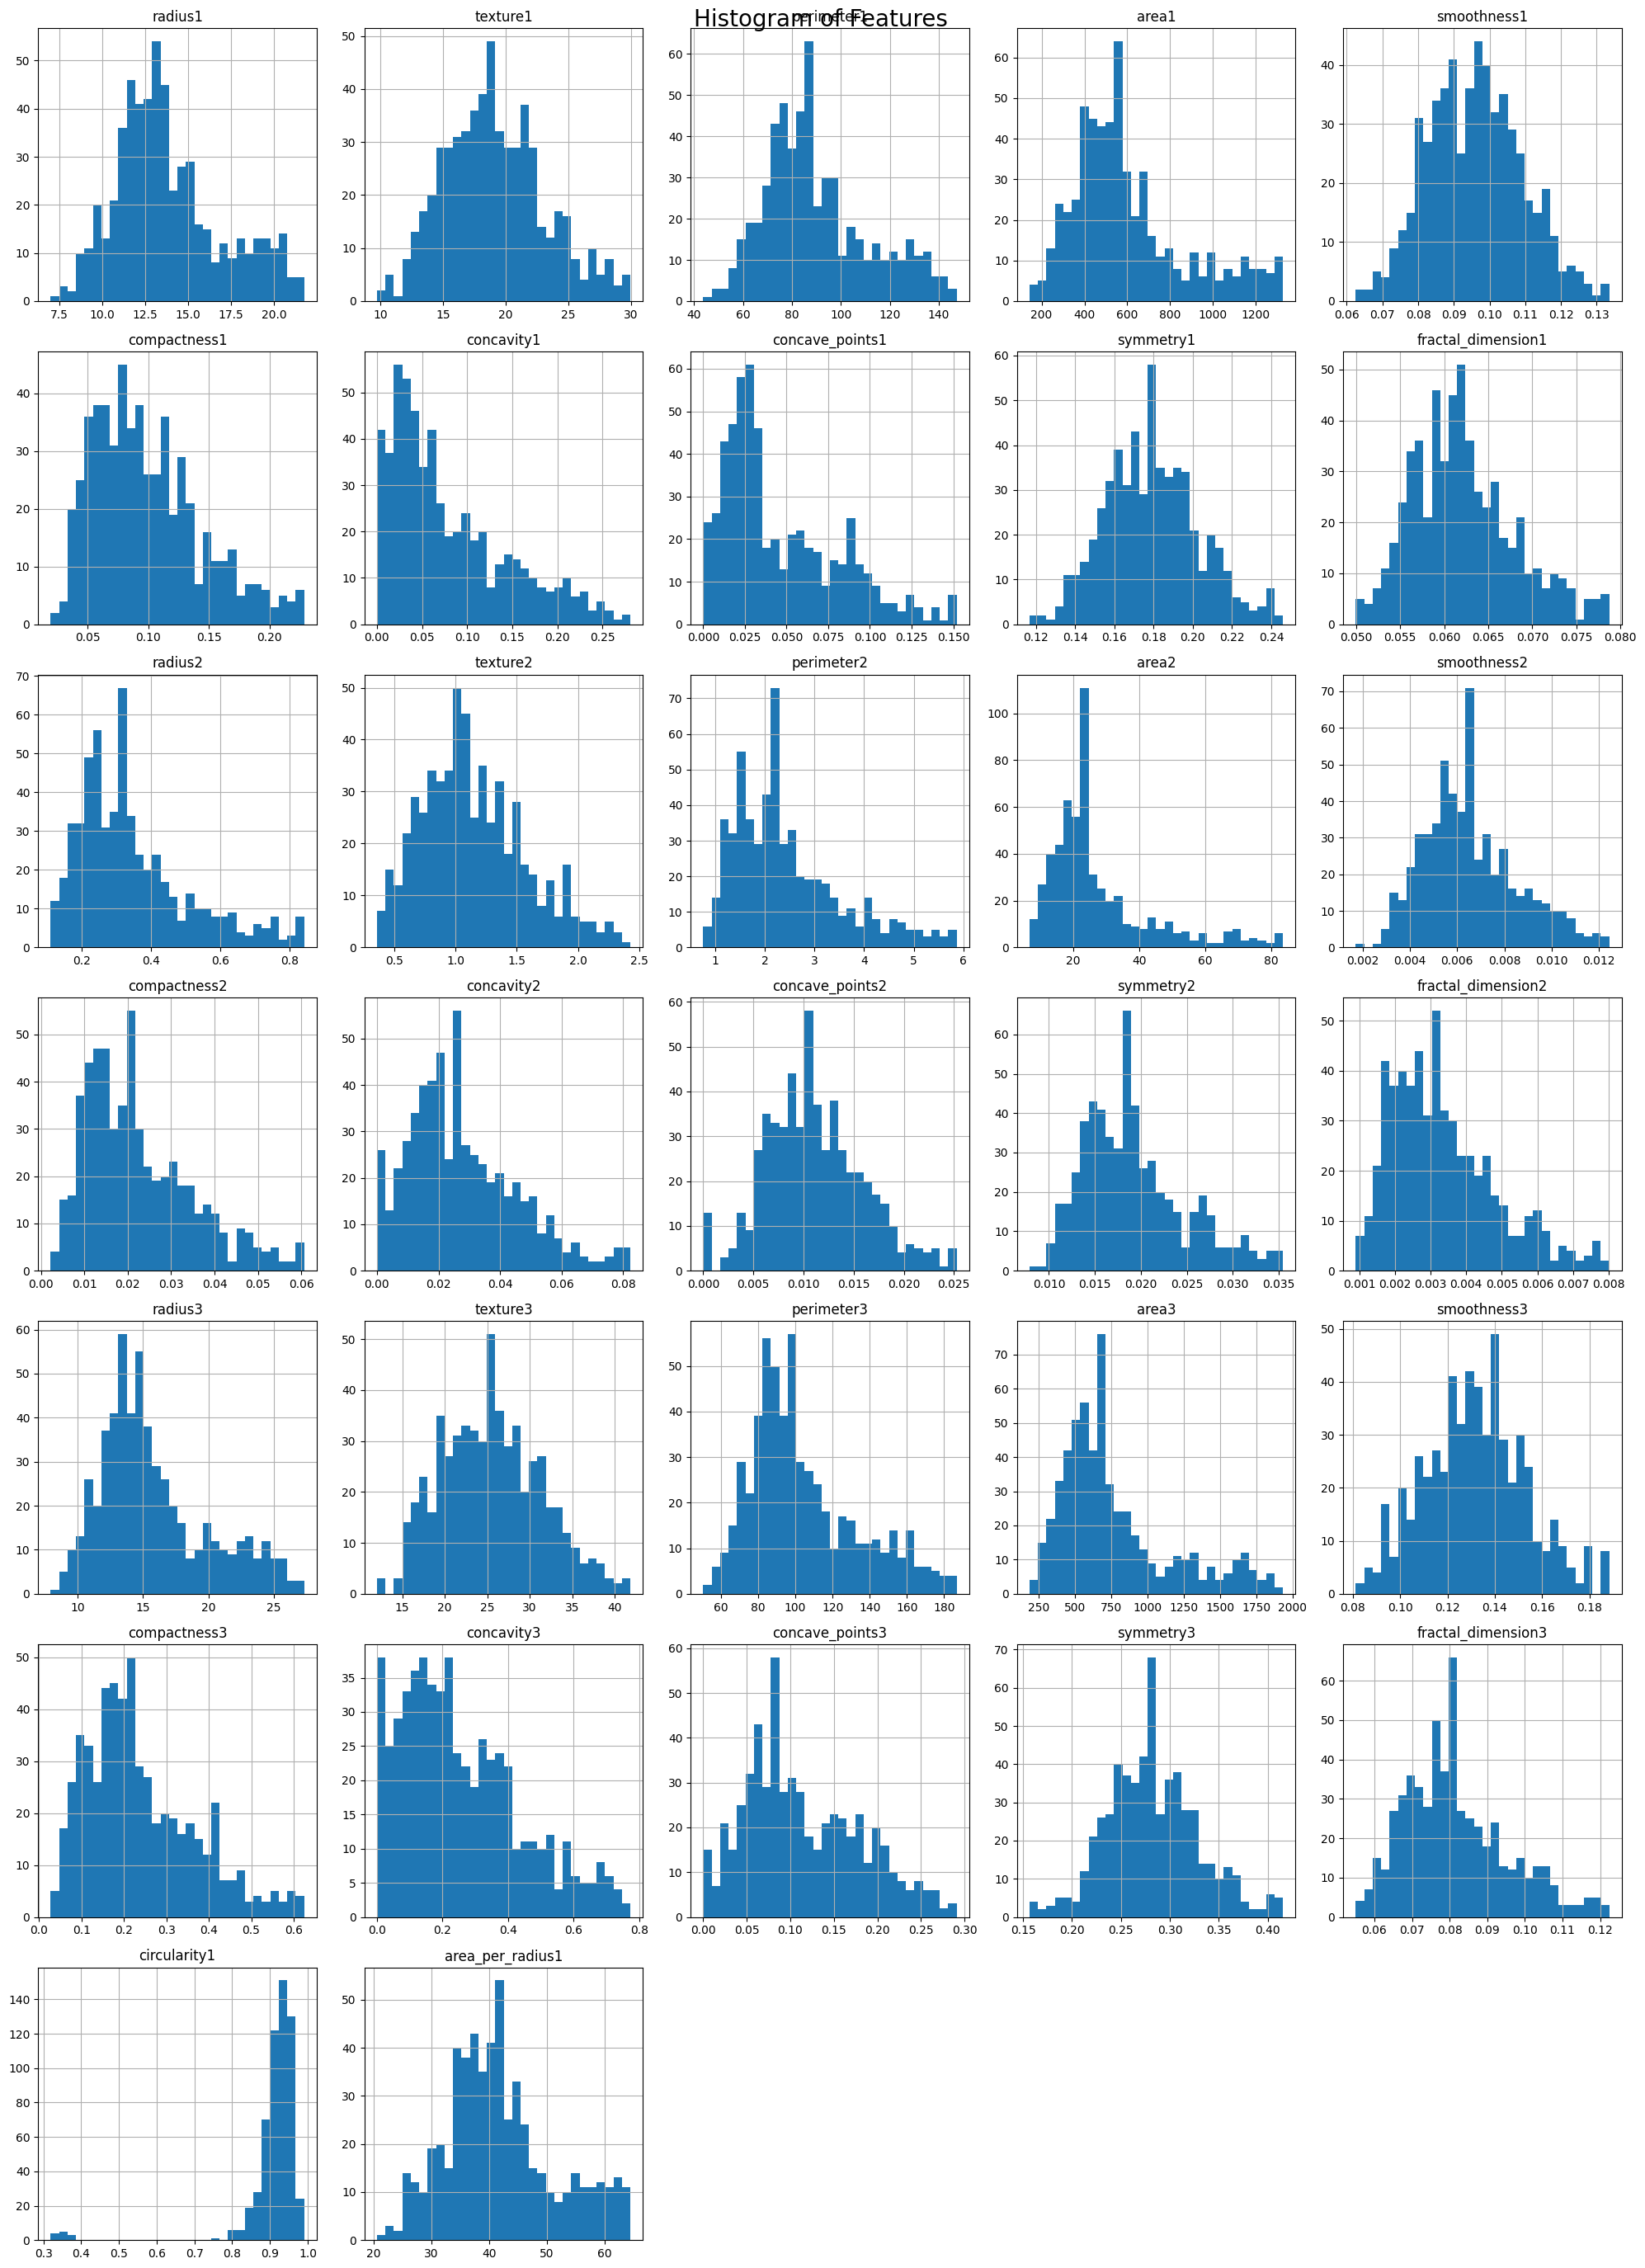

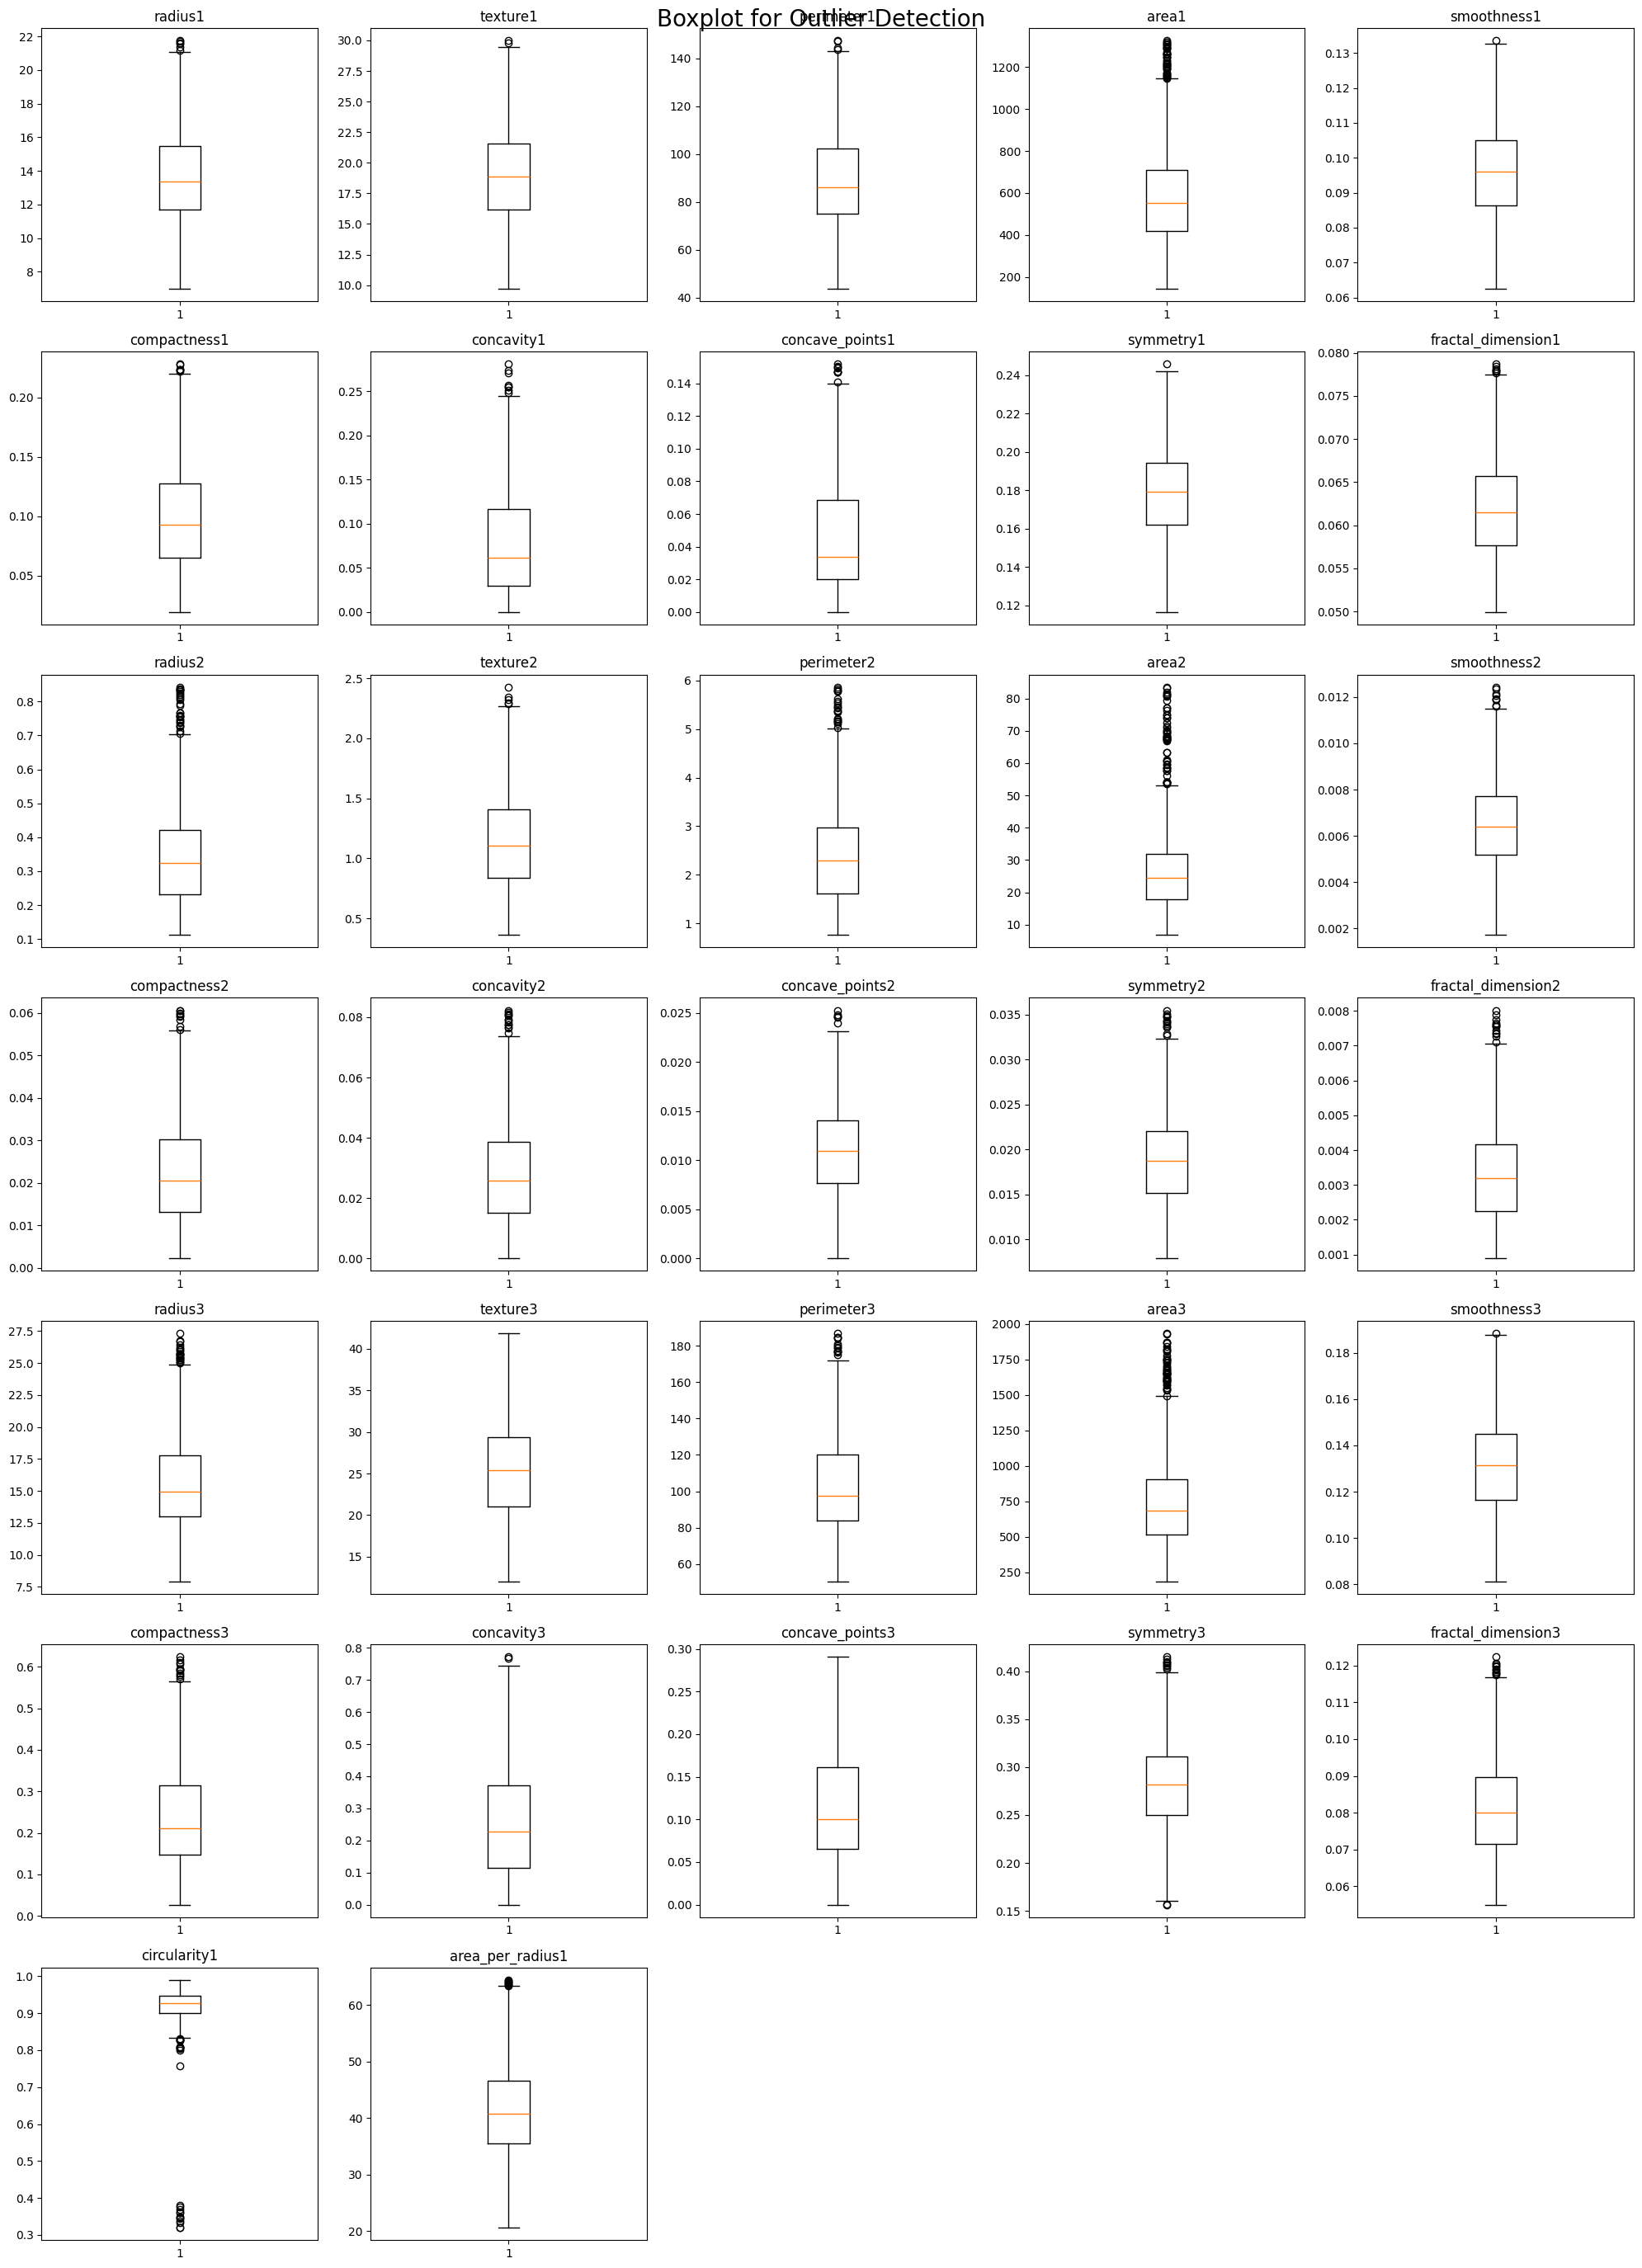

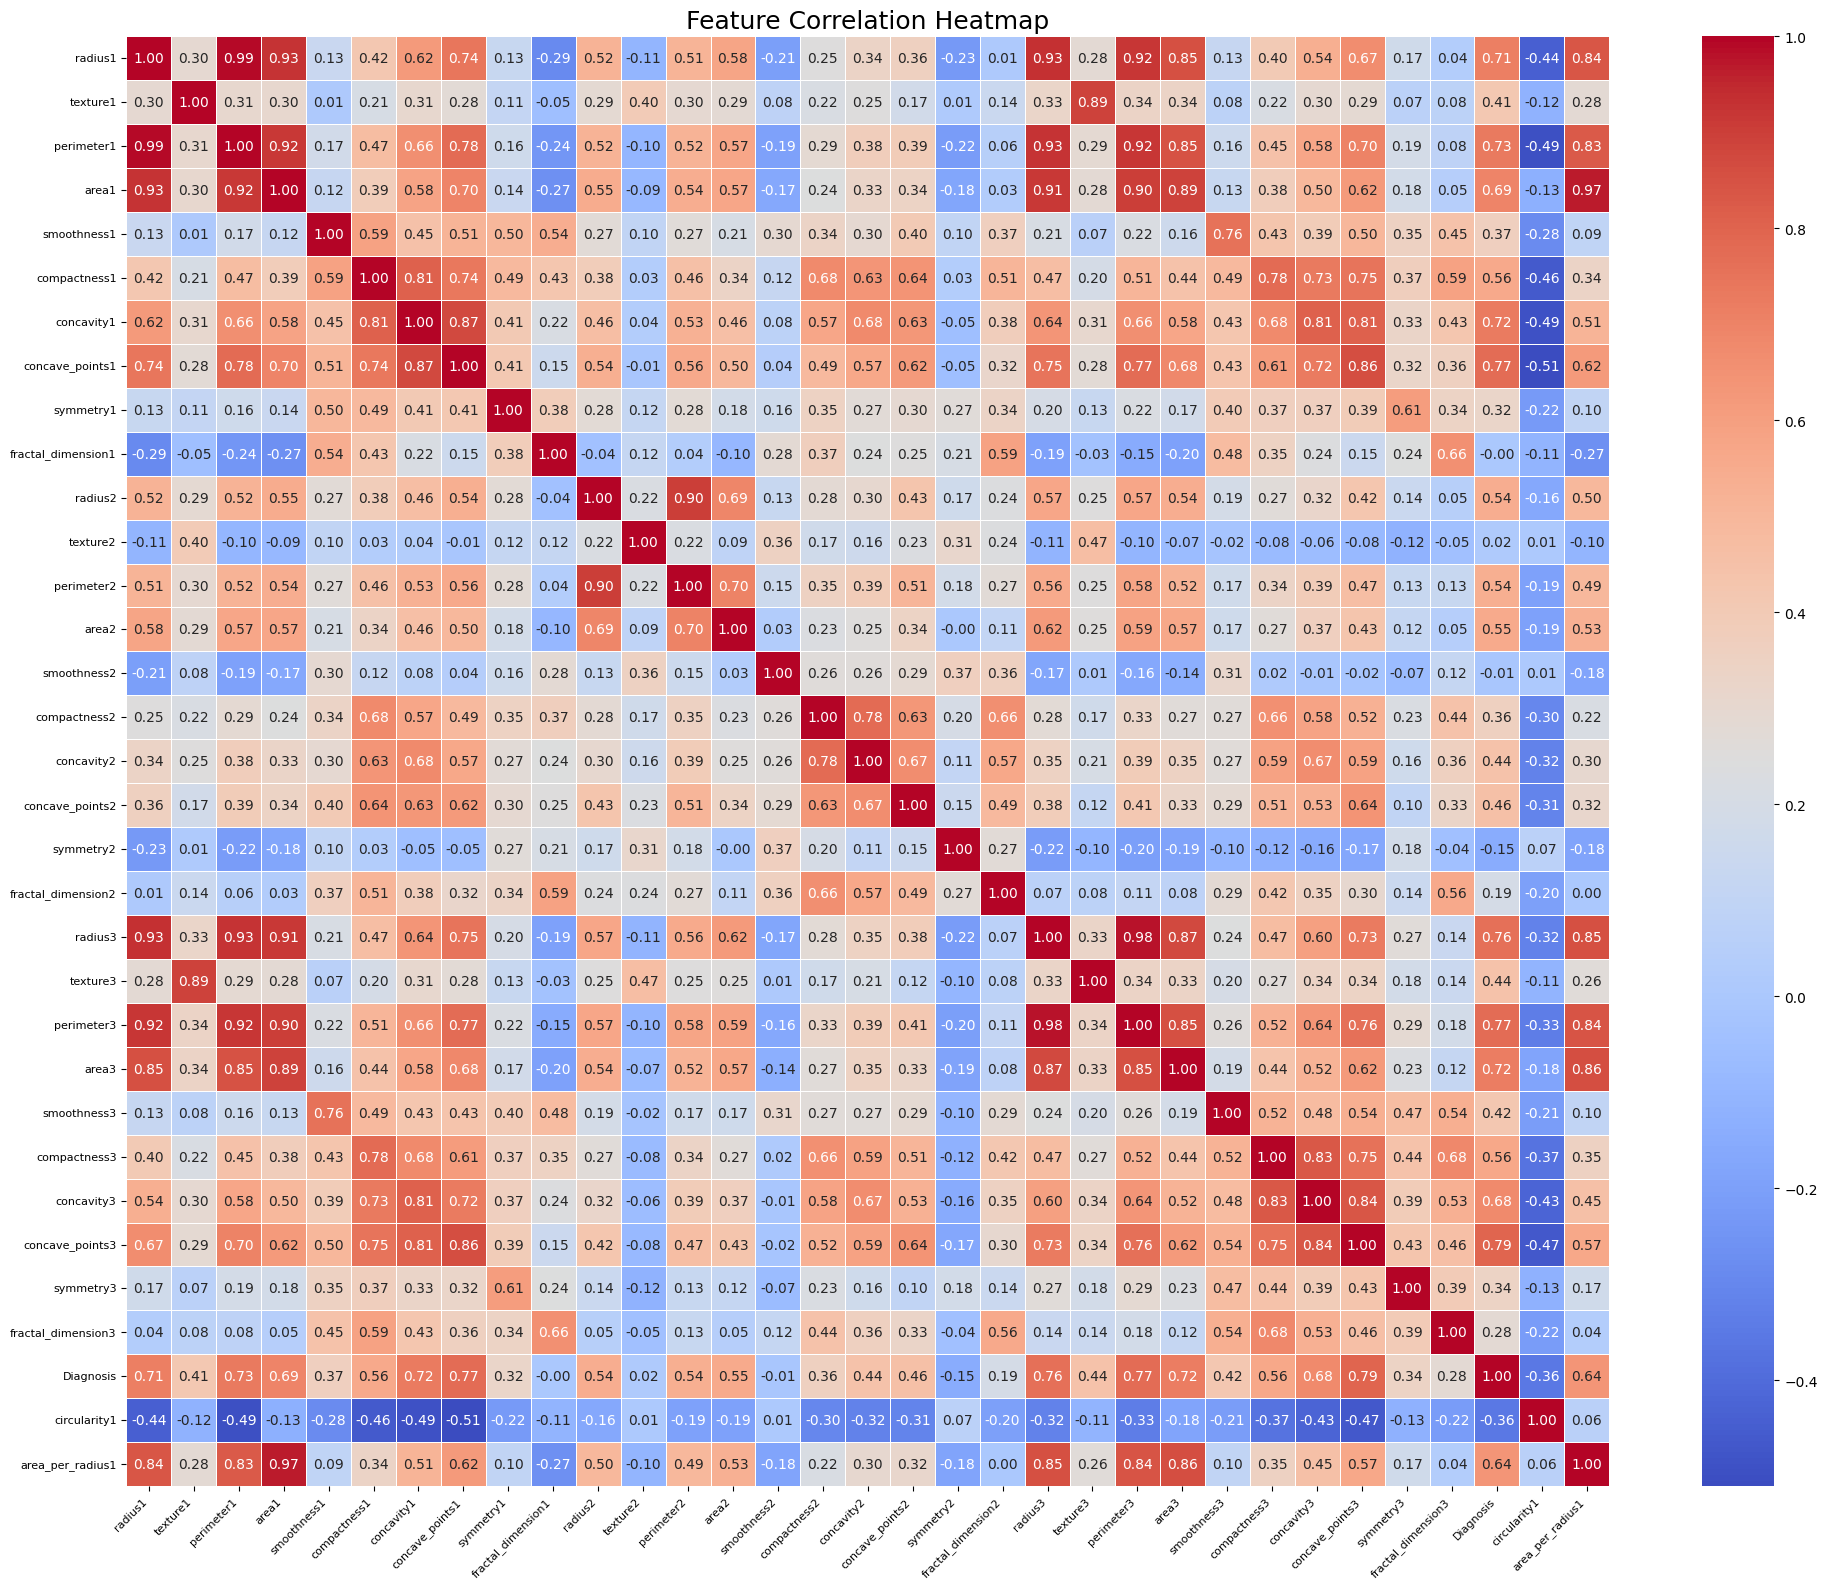

In [ ]:
# --- Histogram Subplots ---
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != target]
n_cols = 5  # Number of plots per row
n_rows = int(np.ceil(len(numerical_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    df[col].hist(ax=axes[i], bins=30)
    axes[i].set_title(col)

# Turn off unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Histogram of Features", fontsize=20)
plt.tight_layout()
plt.show()

# --- Boxplot Subplots ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].boxplot(df[col])
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Boxplot for Outlier Detection", fontsize=20)
plt.tight_layout()
plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
# (iv) Splitting dataset

X = df.drop(columns=[target])
y = df[target]

# Splitting: Train (60%), Validation (20%), Test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}')

Train: (341, 32), Validation: (114, 32), Test: (114, 32)


In [ ]:
# =====================================================
# Storage for results
# =====================================================
best_models = {}
y_val_preds = {}
y_test_preds = {}

scoring = 'accuracy'

# -----------------------------------------------------
# Helper: Train, store, print results
# -----------------------------------------------------
def train_and_store(name, grid, X_train, y_train, X_val, X_test, y_val, y_test, pca_suffix=""):
    grid.fit(X_train, y_train)
    model = grid.best_estimator_
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    key = f"{name}{pca_suffix}"
    best_models[key] = model
    y_val_preds[key] = y_val_pred
    y_test_preds[key] = y_test_pred

    print(f"\n{name}{pca_suffix} best params:", grid.best_params_)
    print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    return model

# -----------------------------------------------------
# Helper: PCA transform
# -----------------------------------------------------
def get_pca_data(X_train, X_val, X_test, n_components=0.95):
    pca = PCA(n_components=n_components)
    return (pca.fit_transform(X_train),
            pca.transform(X_val),
            pca.transform(X_test),
            pca)

# =====================================================
# Define parameter grids
# =====================================================
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 5, 10]
}
param_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10, 20],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7]
}
param_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'estimator': [
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=2),
        DecisionTreeClassifier(max_depth=3)
    ]
}
param_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}
param_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.5, 1, 5]
}
param_svm = {
    "svm__kernel": ["linear", "rbf", "poly"],
    "svm__C": [0.1, 1, 10],
    "svm__gamma": ["scale", "auto"]
}

In [ ]:
# =====================================================
# Train Non-PCA Models
# =====================================================
dt_model = train_and_store("DecisionTree", GridSearchCV(
    DecisionTreeClassifier(random_state=42), param_dt, cv=5, scoring=scoring, n_jobs=-1),
    X_train, y_train, X_val, X_test, y_val, y_test
)

rf_model = train_and_store("RandomForest", GridSearchCV(
    RandomForestClassifier(random_state=42), param_rf, cv=5, scoring=scoring, n_jobs=-1),
    X_train, y_train, X_val, X_test, y_val, y_test
)

ab_model = train_and_store("AdaBoost", GridSearchCV(
    AdaBoostClassifier(random_state=42), param_ab, cv=5, scoring=scoring, n_jobs=-1),
    X_train, y_train, X_val, X_test, y_val, y_test
)

gb_model = train_and_store("GradientBoost", GridSearchCV(
    GradientBoostingClassifier(random_state=42), param_gb, cv=5, scoring=scoring, n_jobs=-1),
    X_train, y_train, X_val, X_test, y_val, y_test
)

xgb_model = train_and_store("XGBoost", GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_xgb, cv=5, scoring=scoring, n_jobs=-1),
    X_train, y_train, X_val, X_test, y_val, y_test
)

svm_model = train_and_store("SVM", GridSearchCV(
    Pipeline([("scaler", StandardScaler()), ("svm", SVC(probability=True, random_state=42))]),
    param_svm, cv=5, scoring=scoring, n_jobs=-1),
    X_train, y_train, X_val, X_test, y_val, y_test
)

# =====================================================
# Stacking Classifiers (Non-PCA)
# =====================================================
stack1 = StackingClassifier(
    estimators=[("svm", svm_model), ("nb", GaussianNB()), ("dt", dt_model)],
    final_estimator=LogisticRegression(max_iter=500, random_state=42),
    cv=5, n_jobs=-1
)
stack2 = StackingClassifier(
    estimators=[("svm", svm_model), ("nb", GaussianNB()), ("dt", dt_model)],
    final_estimator=RandomForestClassifier(n_estimators=200, random_state=42),
    cv=5, n_jobs=-1
)
stack3 = StackingClassifier(
    estimators=[("svm", svm_model), ("dt", dt_model),
                ("knn", Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())]))],
    final_estimator=LogisticRegression(max_iter=500, random_state=42),
    cv=5, n_jobs=-1
)

for name, model in {
    "Stacked_LogReg": stack1,
    "Stacked_RF": stack2,
    "Stacked_LogReg_KNN": stack3
}.items():
    model.fit(X_train, y_train)
    y_val_preds[name] = model.predict(X_val)
    y_test_preds[name] = model.predict(X_test)
    best_models[name] = model


DecisionTree best params: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Validation Accuracy: 0.9474
Test Accuracy: 0.9298

RandomForest best params: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Validation Accuracy: 0.9649
Test Accuracy: 0.9561

AdaBoost best params: {'estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 1, 'n_estimators': 50}
Validation Accuracy: 0.9737
Test Accuracy: 0.9649

GradientBoost best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Validation Accuracy: 0.9737
Test Accuracy: 0.9561


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:09:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost best params: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Validation Accuracy: 0.9737
Test Accuracy: 0.9386

SVM best params: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Validation Accuracy: 0.9649
Test Accuracy: 0.9737


In [ ]:
# =====================================================
# PCA branch
# =====================================================
X_train_pca, X_val_pca, X_test_pca, pca = get_pca_data(X_train, X_val, X_test)

dt_model_pca = train_and_store("DecisionTree", GridSearchCV(
    DecisionTreeClassifier(random_state=42), param_dt, cv=5, scoring=scoring, n_jobs=-1),
    X_train_pca, y_train, X_val_pca, X_test_pca, y_val, y_test, "_PCA"
)

rf_model_pca = train_and_store("RandomForest", GridSearchCV(
    RandomForestClassifier(random_state=42), param_rf, cv=5, scoring=scoring, n_jobs=-1),
    X_train_pca, y_train, X_val_pca, X_test_pca, y_val, y_test, "_PCA"
)

ab_model_pca = train_and_store("AdaBoost", GridSearchCV(
    AdaBoostClassifier(random_state=42), param_ab, cv=5, scoring=scoring, n_jobs=-1),
    X_train_pca, y_train, X_val_pca, X_test_pca, y_val, y_test, "_PCA"
)

gb_model_pca = train_and_store("GradientBoost", GridSearchCV(
    GradientBoostingClassifier(random_state=42), param_gb, cv=5, scoring=scoring, n_jobs=-1),
    X_train_pca, y_train, X_val_pca, X_test_pca, y_val, y_test, "_PCA"
)

xgb_model_pca = train_and_store("XGBoost", GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_xgb, cv=5, scoring=scoring, n_jobs=-1),
    X_train_pca, y_train, X_val_pca, X_test_pca, y_val, y_test, "_PCA"
)

svm_model_pca = train_and_store("SVM", GridSearchCV(
    Pipeline([("scaler", StandardScaler()), ("svm", SVC(probability=True, random_state=42))]),
    param_svm, cv=5, scoring=scoring, n_jobs=-1),
    X_train_pca, y_train, X_val_pca, X_test_pca, y_val, y_test, "_PCA"
)

# =====================================================
# Stacking Classifiers (PCA)
# =====================================================
stack1_pca = StackingClassifier(
    estimators=[("svm", svm_model_pca), ("nb", GaussianNB()), ("dt", dt_model_pca)],
    final_estimator=LogisticRegression(max_iter=500, random_state=42),
    cv=5, n_jobs=-1
)
stack2_pca = StackingClassifier(
    estimators=[("svm", svm_model_pca), ("nb", GaussianNB()), ("dt", dt_model_pca)],
    final_estimator=RandomForestClassifier(n_estimators=200, random_state=42),
    cv=5, n_jobs=-1
)
stack3_pca = StackingClassifier(
    estimators=[("svm", svm_model_pca), ("dt", dt_model_pca),
                ("knn", Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())]))],
    final_estimator=LogisticRegression(max_iter=500, random_state=42),
    cv=5, n_jobs=-1
)

for name, model in {
    "Stacked_LogReg_PCA": stack1_pca,
    "Stacked_RF_PCA": stack2_pca,
    "Stacked_LogReg_KNN_PCA": stack3_pca
}.items():
    model.fit(X_train_pca, y_train)
    y_val_preds[name] = model.predict(X_val_pca)
    y_test_preds[name] = model.predict(X_test_pca)
    best_models[name] = model


DecisionTree_PCA best params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
Validation Accuracy: 0.9035
Test Accuracy: 0.9386

RandomForest_PCA best params: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Validation Accuracy: 0.8684
Test Accuracy: 0.8947

AdaBoost_PCA best params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.1, 'n_estimators': 50}
Validation Accuracy: 0.9035
Test Accuracy: 0.9386

GradientBoost_PCA best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}
Validation Accuracy: 0.9035
Test Accuracy: 0.9386


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:18:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost_PCA best params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Validation Accuracy: 0.8947
Test Accuracy: 0.9298

SVM_PCA best params: {'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Validation Accuracy: 0.8772
Test Accuracy: 0.9211


In [ ]:
# Evaluating Model using Performance Metrics

def evaluate_model(y_true, y_pred, is_classification, X, model, dataset_name):
    print(f"\n Evaluation - {dataset_name}")
    if is_classification:
        print("Accuracy :", round(accuracy_score(y_true, y_pred), 4))
        print("Precision:", round(precision_score(y_true, y_pred, average='weighted'), 4))
        print("Recall   :", round(recall_score(y_true, y_pred, average='weighted'), 4))
        print("F1 Score :", round(f1_score(y_true, y_pred, average='weighted'), 4))
        print("\nClassification Report:\n", classification_report(y_true, y_pred))

        # ROC Curve: Only for binary classification
        if len(np.unique(y_true)) == 2 and model is not None and hasattr(model, "predict_proba"):
            y_probs = model.predict_proba(X)[:, 1]
            fpr, tpr, _ = roc_curve(y_true, y_probs)
            auc_score = roc_auc_score(y_true, y_probs)
            print("ROC AUC Score:", round(auc_score, 4))

            # Plot ROC
            plt.figure(figsize=(6, 4))
            plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
            plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve - {dataset_name}")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    else:
        n, p = X.shape
        r2 = r2_score(y_true, y_pred)
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        print("Mean Squared Error:", mean_squared_error(y_true, y_pred))
        print("Root Mean Squared Error:", root_mean_squared_error(y_true, y_pred))
        print("Mean Absolute Error:", mean_absolute_error(y_true, y_pred))
        print("R2 Score:", r2)
        print("Adjusted R2 Score:", adjusted_r2)


In [ ]:
# Evaluating Model on Test and Validation Sets (Without Performance Metrics)

def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolor='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.5, edgecolor='k')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residual_distribution(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, color='skyblue')
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(title)
    plt.show()

In [ ]:
for i in best_models:
  print(i, best_models[i])

DecisionTree DecisionTreeClassifier(min_samples_leaf=10, random_state=42)
RandomForest RandomForestClassifier(min_samples_split=5, n_estimators=200, random_state=42)
AdaBoost AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=1, random_state=42)
GradientBoost GradientBoostingClassifier(random_state=42, subsample=0.8)
XGBoost XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.5,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, m

Processing DecisionTree

--- DecisionTree ---

 Evaluation - Test Set
Accuracy : 0.9298
Precision: 0.9313
Recall   : 0.9298
F1 Score : 0.9303

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95        76
           1       0.88      0.92      0.90        38

    accuracy                           0.93       114
   macro avg       0.92      0.93      0.92       114
weighted avg       0.93      0.93      0.93       114

ROC AUC Score: 0.952


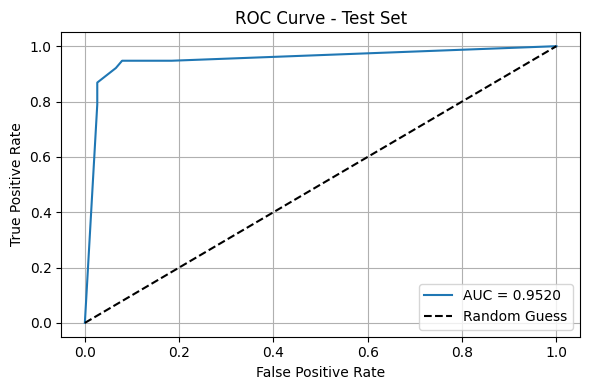

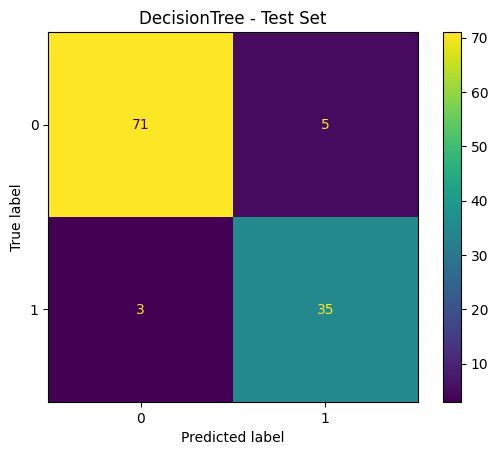

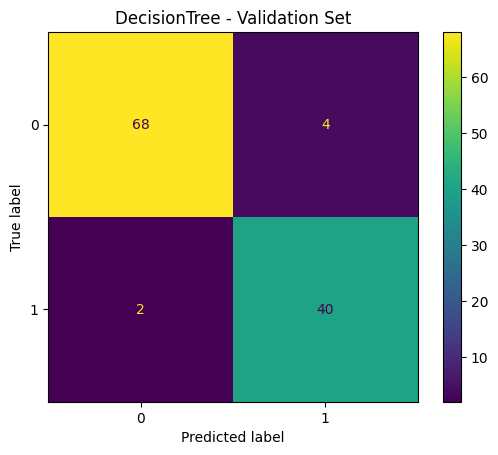

Cross Validation Scores: [0.92753623 0.85294118 0.97058824 0.95588235 0.94117647]
Average CV Score: 0.929624893435635
Processing DecisionTree_PCA

--- DecisionTree_PCA ---

 Evaluation - Test Set
Accuracy : 0.9386
Precision: 0.9438
Recall   : 0.9386
F1 Score : 0.9368

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        76
           1       1.00      0.82      0.90        38

    accuracy                           0.94       114
   macro avg       0.96      0.91      0.93       114
weighted avg       0.94      0.94      0.94       114

ROC AUC Score: 0.9688


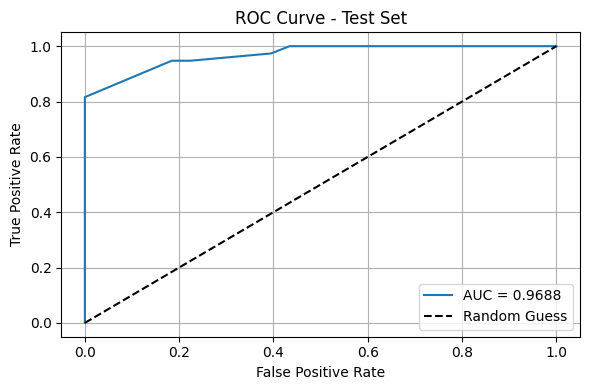

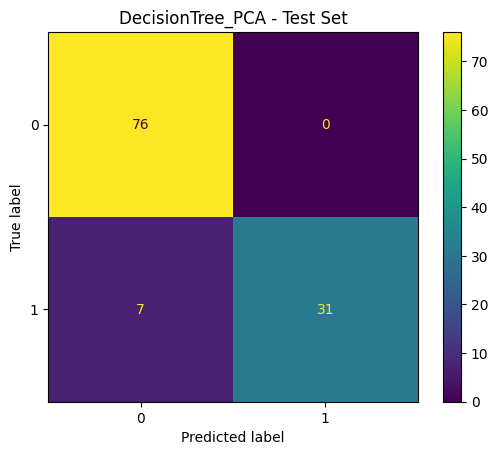

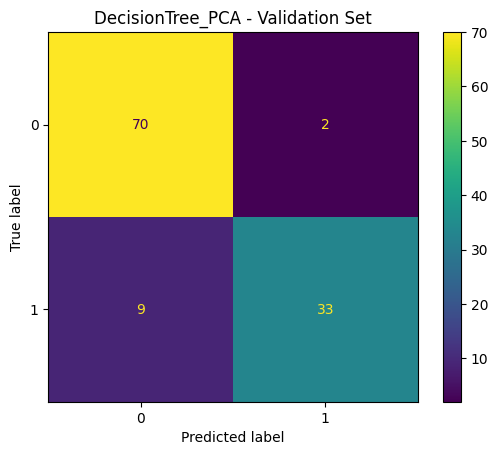

Cross Validation Scores: [0.88405797 0.91176471 0.82352941 0.83823529 0.85294118]
Average CV Score: 0.8621057118499573
Processing RandomForest

--- RandomForest ---

 Evaluation - Test Set
Accuracy : 0.9561
Precision: 0.956
Recall   : 0.9561
F1 Score : 0.956

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97        76
           1       0.95      0.92      0.93        38

    accuracy                           0.96       114
   macro avg       0.95      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

ROC AUC Score: 0.9962


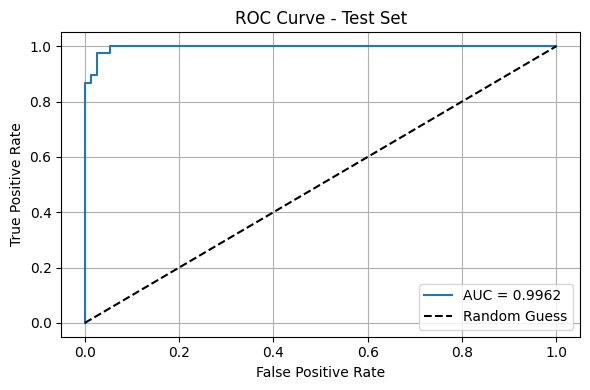

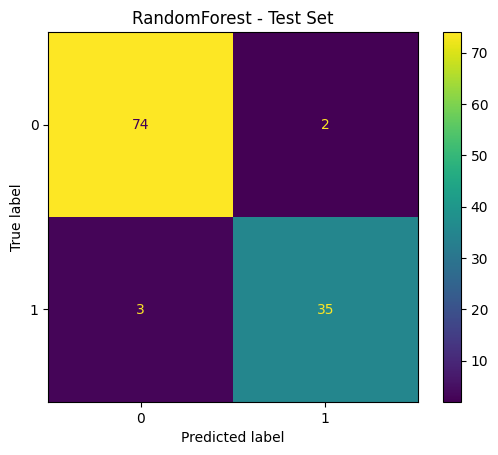

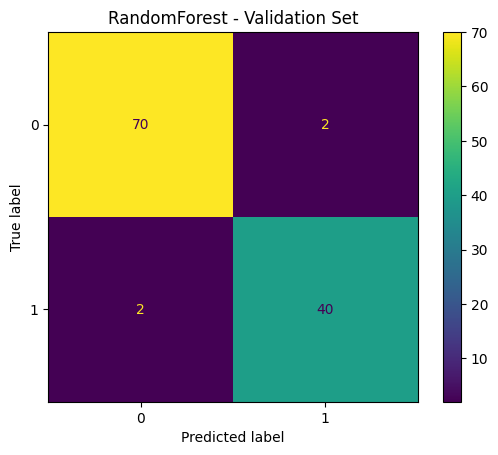

Cross Validation Scores: [0.97101449 0.94117647 0.98529412 0.92647059 0.97058824]
Average CV Score: 0.9589087809036659
Processing RandomForest_PCA

--- RandomForest_PCA ---

 Evaluation - Test Set
Accuracy : 0.8947
Precision: 0.8947
Recall   : 0.8947
F1 Score : 0.8947

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92        76
           1       0.84      0.84      0.84        38

    accuracy                           0.89       114
   macro avg       0.88      0.88      0.88       114
weighted avg       0.89      0.89      0.89       114

ROC AUC Score: 0.969


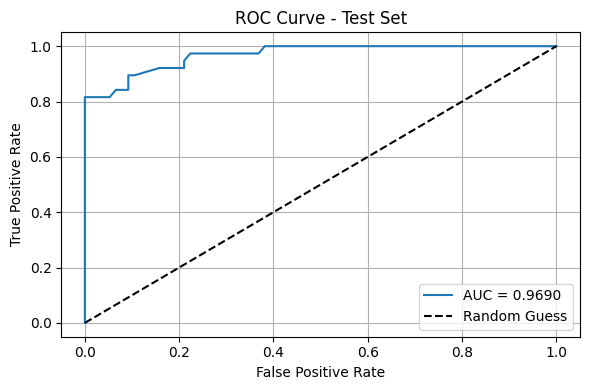

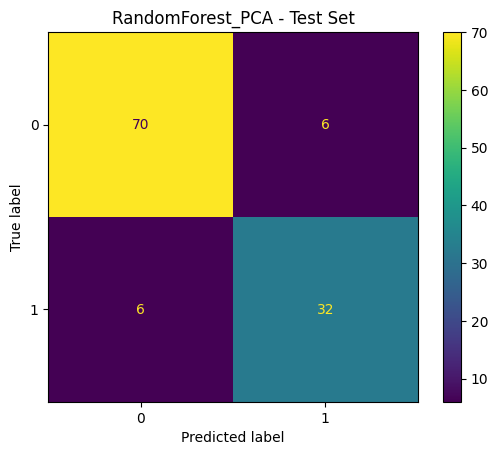

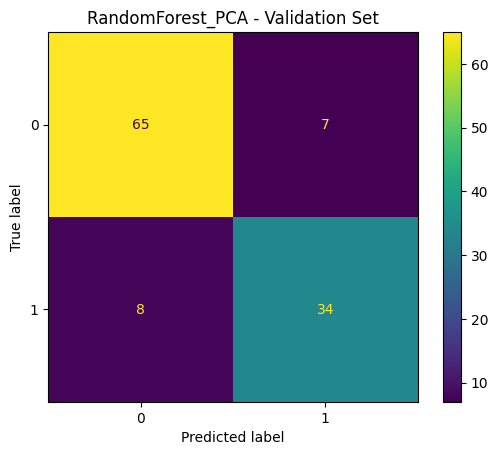

Cross Validation Scores: [0.86956522 0.86764706 0.83823529 0.85294118 0.85294118]
Average CV Score: 0.8562659846547314
Processing AdaBoost

--- AdaBoost ---

 Evaluation - Test Set
Accuracy : 0.9649
Precision: 0.966
Recall   : 0.9649
F1 Score : 0.9651

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97        76
           1       0.93      0.97      0.95        38

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

ROC AUC Score: 0.9969


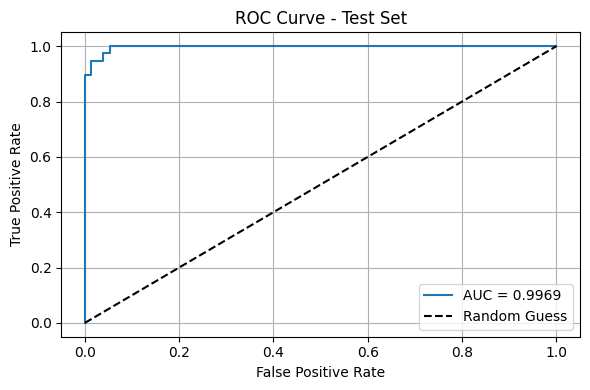

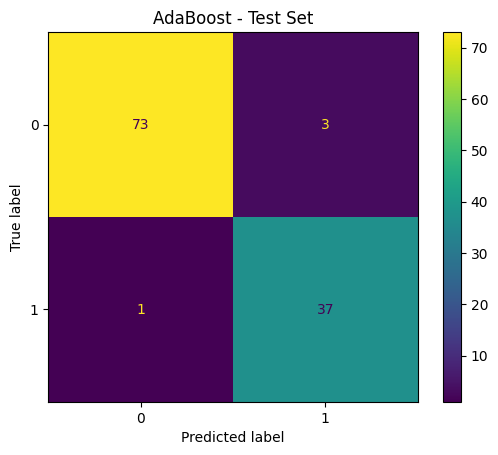

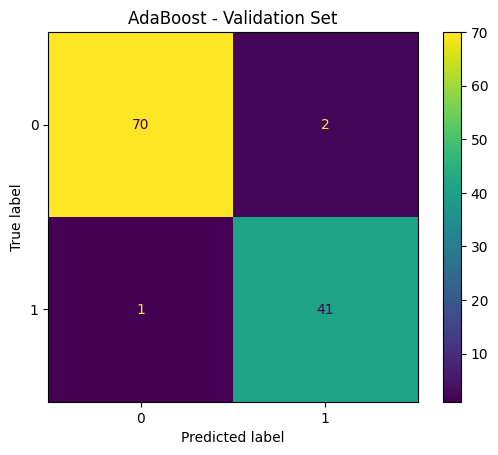

Cross Validation Scores: [0.94202899 0.94117647 0.98529412 0.97058824 0.97058824]
Average CV Score: 0.9619352088661552
Processing AdaBoost_PCA

--- AdaBoost_PCA ---

 Evaluation - Test Set
Accuracy : 0.9386
Precision: 0.9438
Recall   : 0.9386
F1 Score : 0.9368

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        76
           1       1.00      0.82      0.90        38

    accuracy                           0.94       114
   macro avg       0.96      0.91      0.93       114
weighted avg       0.94      0.94      0.94       114

ROC AUC Score: 0.9716


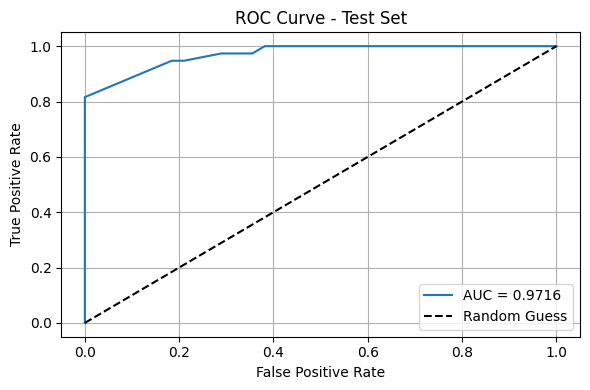

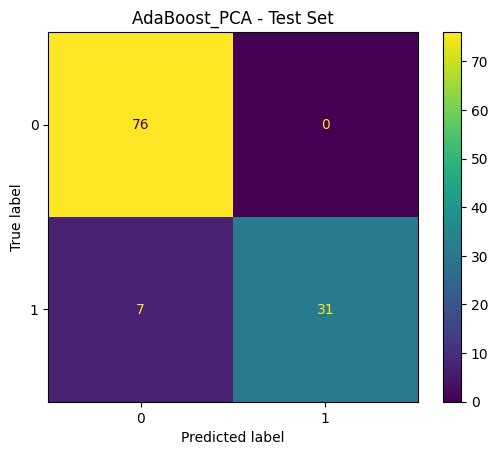

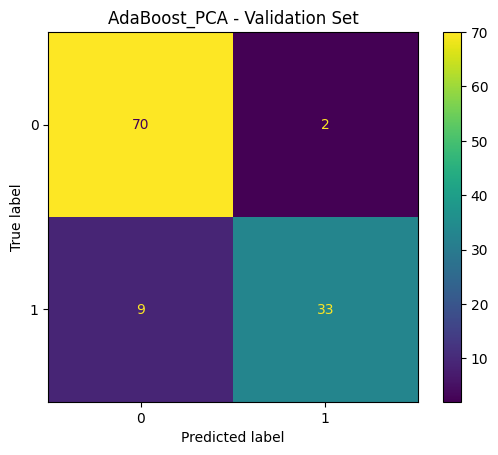

Cross Validation Scores: [0.88405797 0.88235294 0.89705882 0.80882353 0.85294118]
Average CV Score: 0.8650468883205455
Processing GradientBoost

--- GradientBoost ---

 Evaluation - Test Set
Accuracy : 0.9561
Precision: 0.956
Recall   : 0.9561
F1 Score : 0.956

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97        76
           1       0.95      0.92      0.93        38

    accuracy                           0.96       114
   macro avg       0.95      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

ROC AUC Score: 0.9927


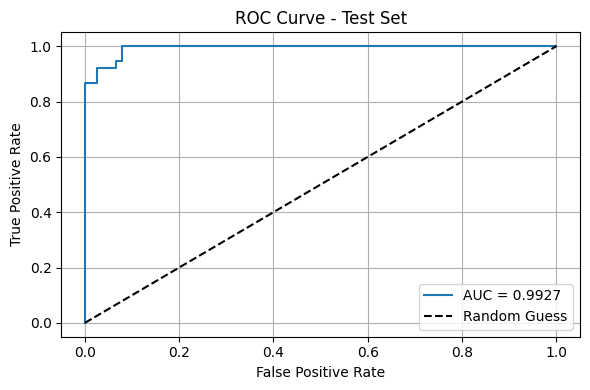

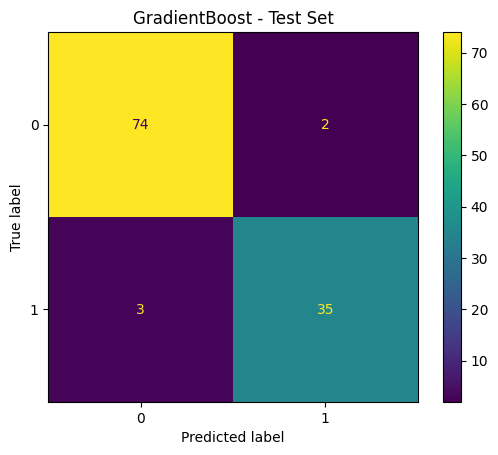

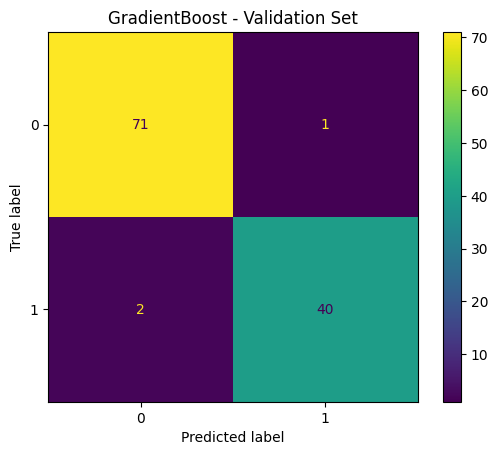

Cross Validation Scores: [0.92753623 0.94117647 0.98529412 0.95588235 0.98529412]
Average CV Score: 0.9590366581415175
Processing GradientBoost_PCA

--- GradientBoost_PCA ---

 Evaluation - Test Set
Accuracy : 0.9386
Precision: 0.9438
Recall   : 0.9386
F1 Score : 0.9368

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        76
           1       1.00      0.82      0.90        38

    accuracy                           0.94       114
   macro avg       0.96      0.91      0.93       114
weighted avg       0.94      0.94      0.94       114

ROC AUC Score: 0.9782


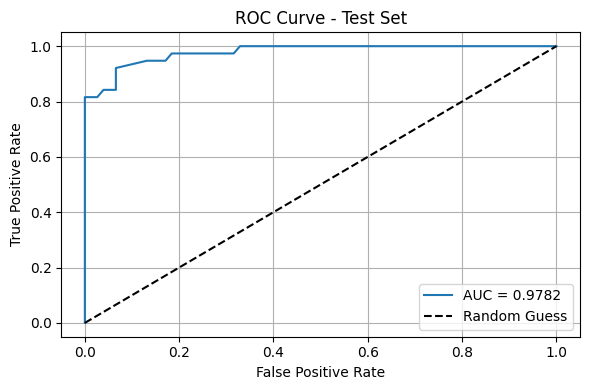

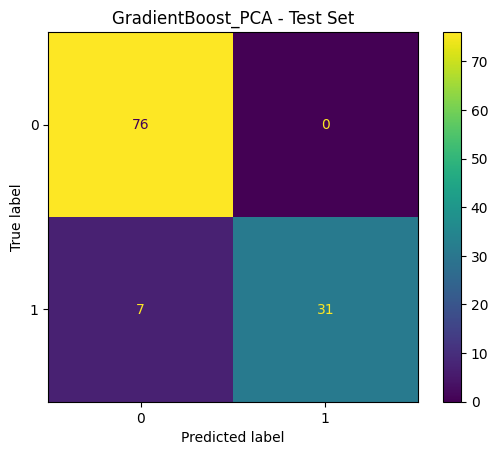

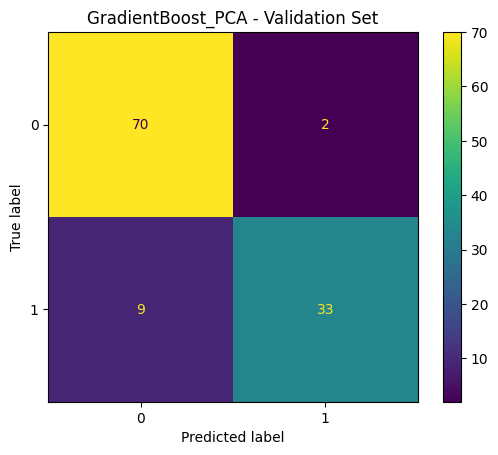

Cross Validation Scores: [0.88405797 0.86764706 0.89705882 0.82352941 0.85294118]
Average CV Score: 0.8650468883205455
Processing XGBoost

--- XGBoost ---

 Evaluation - Test Set
Accuracy : 0.9386
Precision: 0.9383
Recall   : 0.9386
F1 Score : 0.9384

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95        76
           1       0.92      0.89      0.91        38

    accuracy                           0.94       114
   macro avg       0.93      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114

ROC AUC Score: 0.991


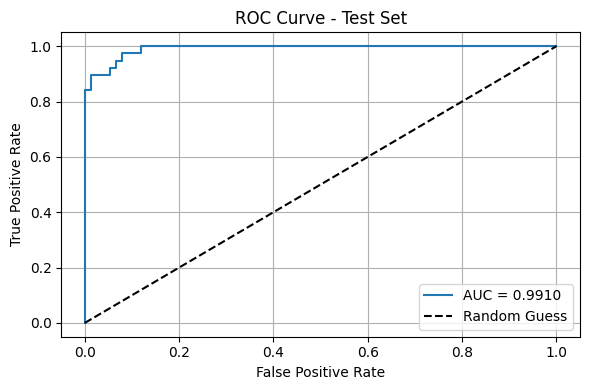

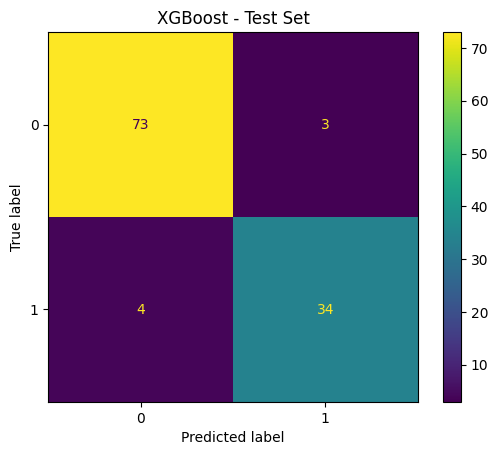

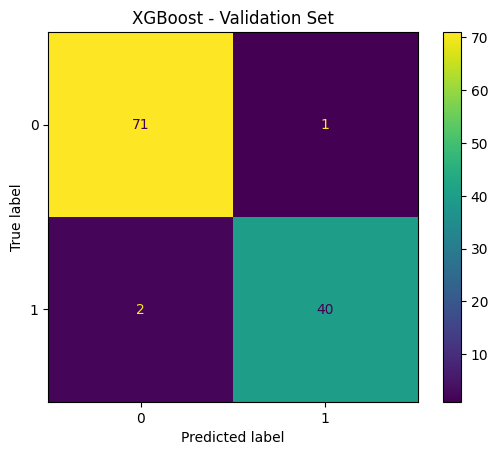

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:47:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:47:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:47:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:47:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:47:43] WARNING: /w

Cross Validation Scores: [0.95652174 0.94117647 0.98529412 0.97058824 0.95588235]
Average CV Score: 0.9618925831202046
Processing XGBoost_PCA

--- XGBoost_PCA ---

 Evaluation - Test Set
Accuracy : 0.9298
Precision: 0.9365
Recall   : 0.9298
F1 Score : 0.9275

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        76
           1       1.00      0.79      0.88        38

    accuracy                           0.93       114
   macro avg       0.95      0.89      0.92       114
weighted avg       0.94      0.93      0.93       114

ROC AUC Score: 0.9823


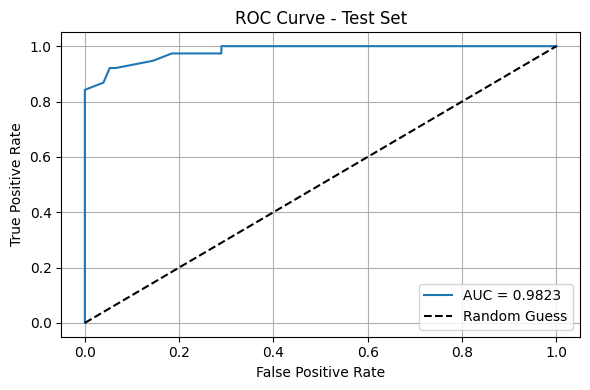

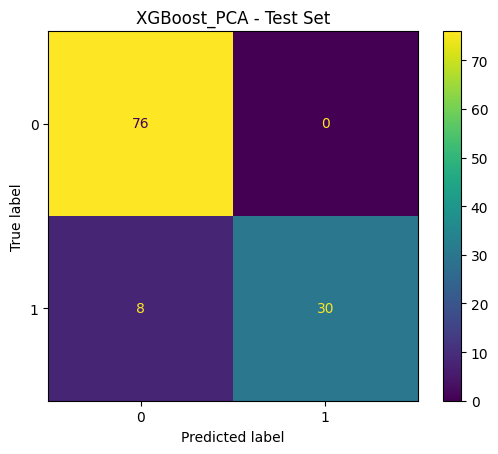

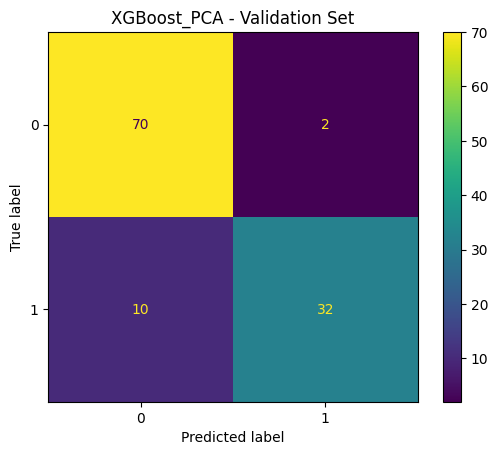

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:47:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:47:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:47:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:47:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:47:44] WARNING: /w

Cross Validation Scores: [0.88405797 0.89705882 0.89705882 0.82352941 0.85294118]
Average CV Score: 0.870929241261722
Processing SVM

--- SVM ---

 Evaluation - Test Set
Accuracy : 0.9737
Precision: 0.9737
Recall   : 0.9737
F1 Score : 0.9736

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        76
           1       0.97      0.95      0.96        38

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

ROC AUC Score: 0.9962


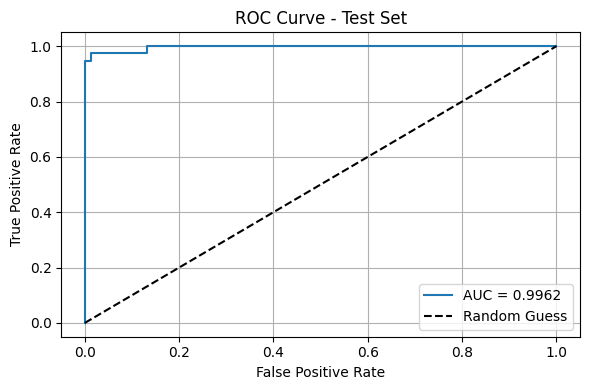

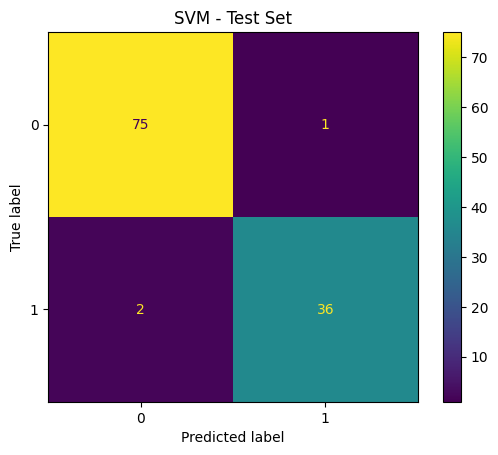

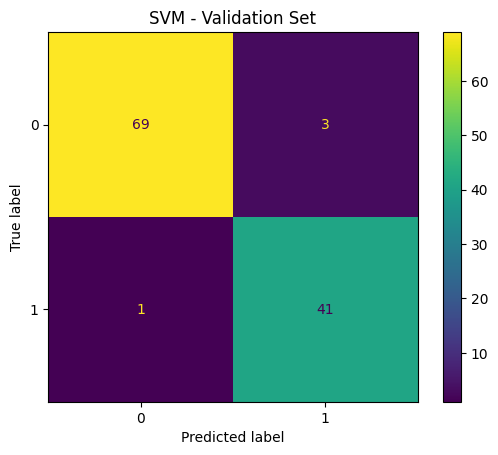

Cross Validation Scores: [0.94202899 0.95588235 0.98529412 0.95588235 0.95588235]
Average CV Score: 0.958994032395567
Processing SVM_PCA

--- SVM_PCA ---

 Evaluation - Test Set
Accuracy : 0.9211
Precision: 0.9294
Recall   : 0.9211
F1 Score : 0.918

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        76
           1       1.00      0.76      0.87        38

    accuracy                           0.92       114
   macro avg       0.95      0.88      0.90       114
weighted avg       0.93      0.92      0.92       114

ROC AUC Score: 0.9595


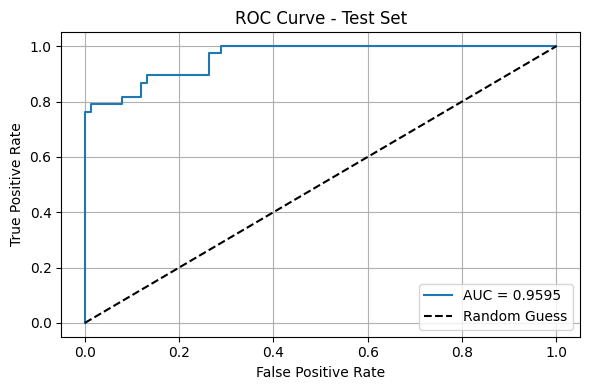

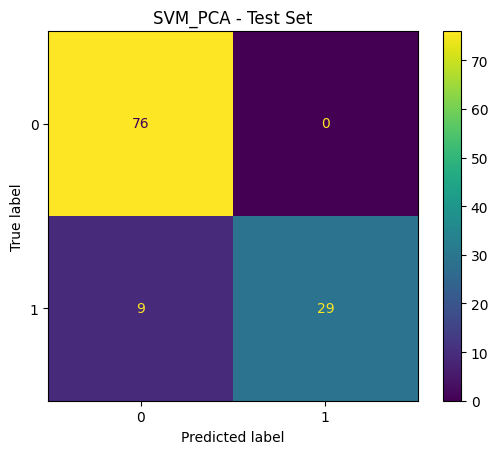

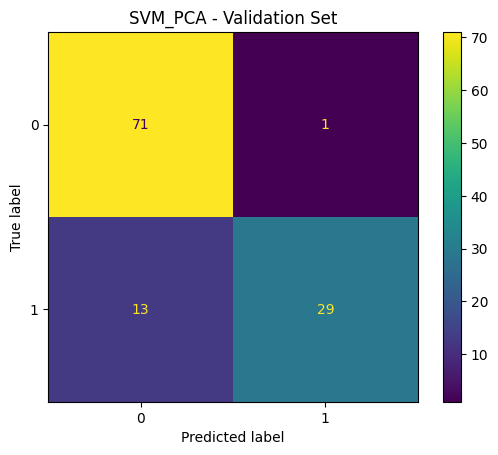

Cross Validation Scores: [0.84057971 0.82352941 0.91176471 0.82352941 0.82352941]
Average CV Score: 0.8445865302642795
Processing Stacked_LogReg

--- Stacked_LogReg ---

 Evaluation - Test Set
Accuracy : 0.9737
Precision: 0.9737
Recall   : 0.9737
F1 Score : 0.9736

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        76
           1       0.97      0.95      0.96        38

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

ROC AUC Score: 0.9962


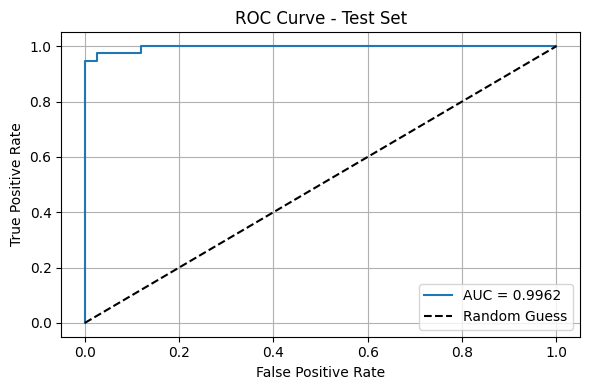

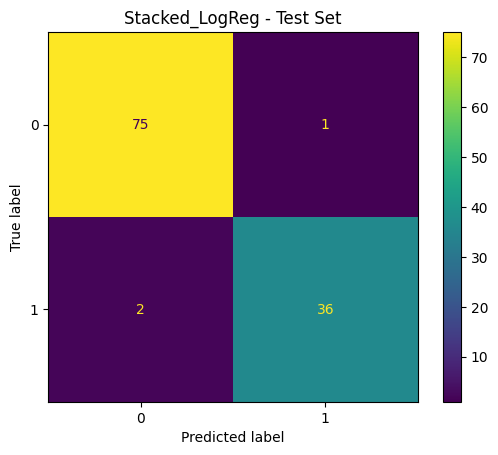

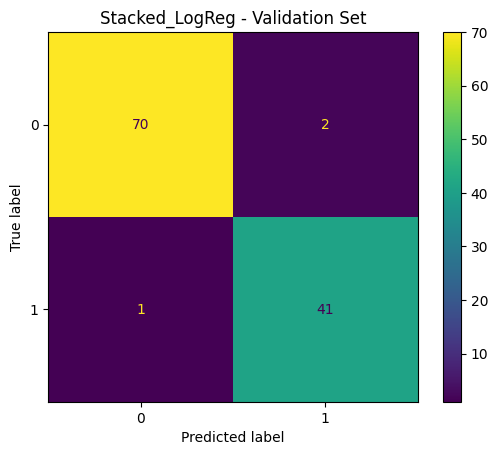

Cross Validation Scores: [0.92753623 0.94117647 0.95588235 0.94117647 0.94117647]
Average CV Score: 0.9413895993179882
Processing Stacked_LogReg_PCA

--- Stacked_LogReg_PCA ---

 Evaluation - Test Set
Accuracy : 0.9386
Precision: 0.9438
Recall   : 0.9386
F1 Score : 0.9368

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        76
           1       1.00      0.82      0.90        38

    accuracy                           0.94       114
   macro avg       0.96      0.91      0.93       114
weighted avg       0.94      0.94      0.94       114

ROC AUC Score: 0.973


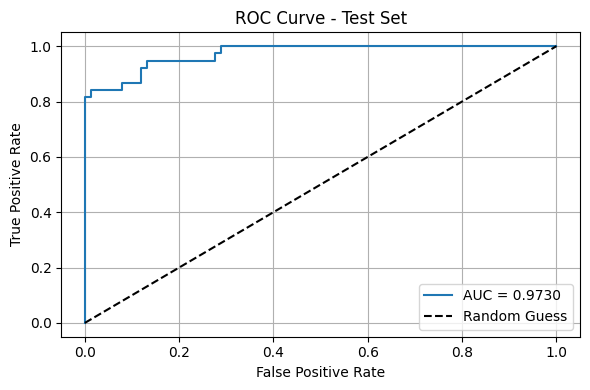

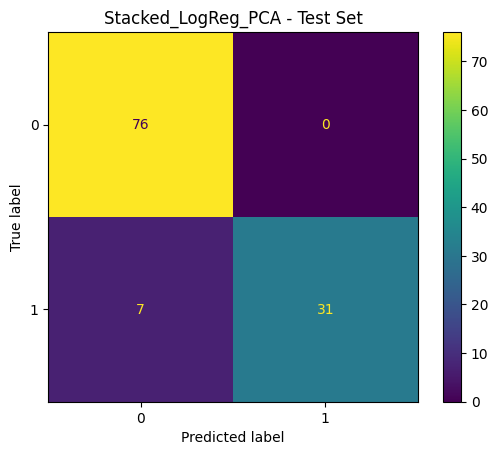

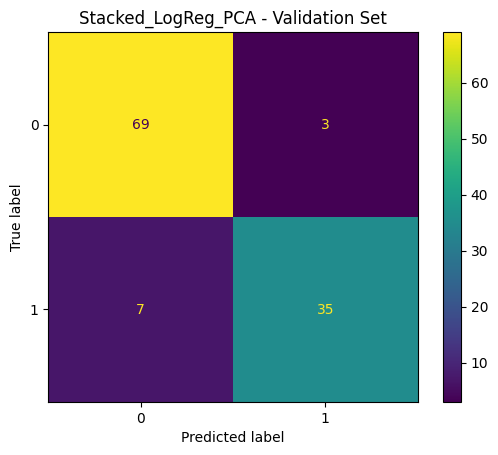

Cross Validation Scores: [0.85507246 0.79411765 0.88235294 0.83823529 0.85294118]
Average CV Score: 0.8445439045183291
Processing Stacked_RF

--- Stacked_RF ---

 Evaluation - Test Set
Accuracy : 0.9825
Precision: 0.9825
Recall   : 0.9825
F1 Score : 0.9825

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        76
           1       0.97      0.97      0.97        38

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

ROC AUC Score: 0.9934


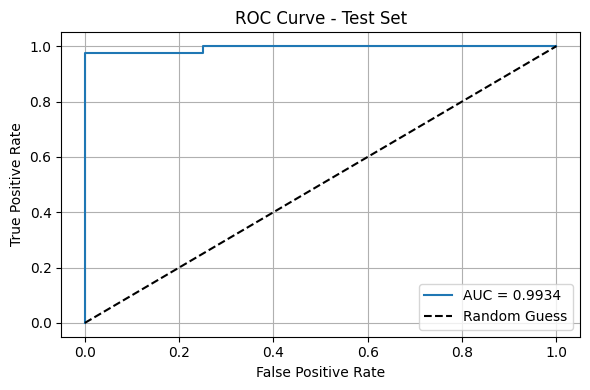

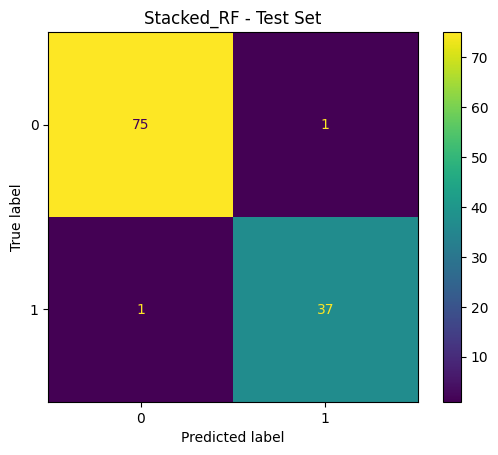

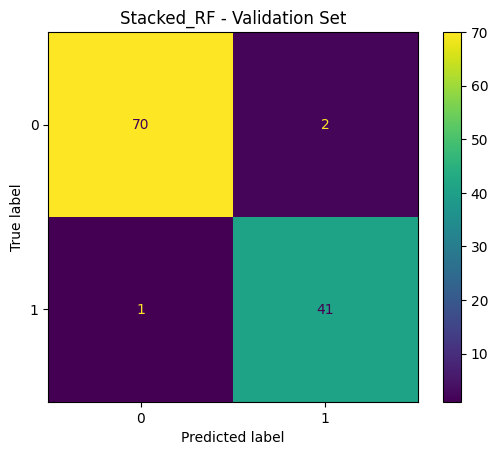

Cross Validation Scores: [0.89855072 0.94117647 0.98529412 0.94117647 0.94117647]
Average CV Score: 0.9414748508098892
Processing Stacked_RF_PCA

--- Stacked_RF_PCA ---

 Evaluation - Test Set
Accuracy : 0.9035
Precision: 0.9066
Recall   : 0.9035
F1 Score : 0.9044

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93        76
           1       0.83      0.89      0.86        38

    accuracy                           0.90       114
   macro avg       0.89      0.90      0.89       114
weighted avg       0.91      0.90      0.90       114

ROC AUC Score: 0.9635


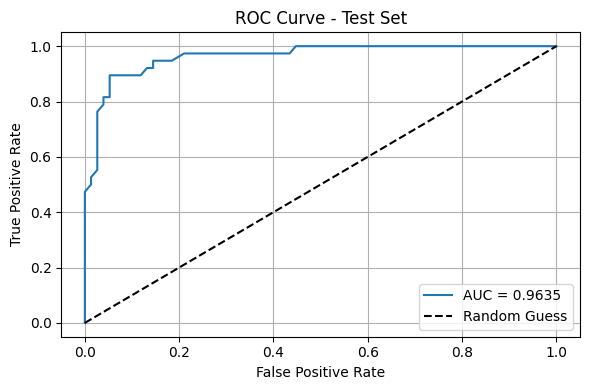

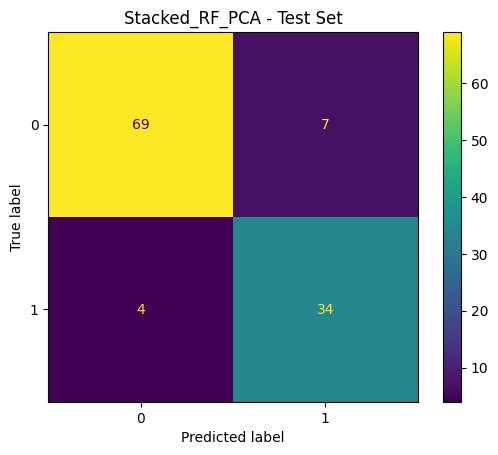

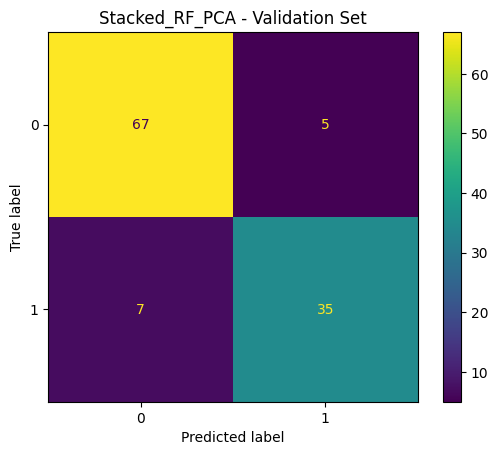

Cross Validation Scores: [0.88405797 0.82352941 0.83823529 0.82352941 0.83823529]
Average CV Score: 0.8415174765558397
Processing Stacked_LogReg_KNN

--- Stacked_LogReg_KNN ---

 Evaluation - Test Set
Accuracy : 0.9825
Precision: 0.9825
Recall   : 0.9825
F1 Score : 0.9825

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        76
           1       0.97      0.97      0.97        38

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

ROC AUC Score: 0.9948


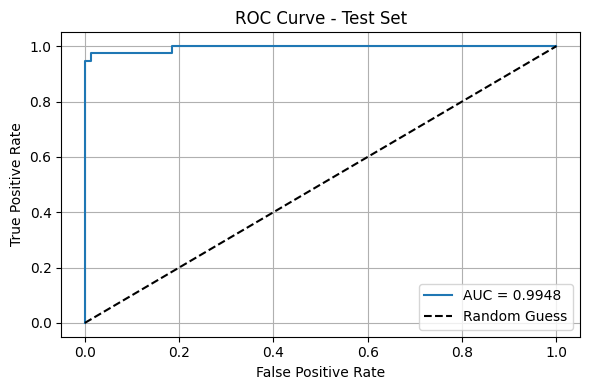

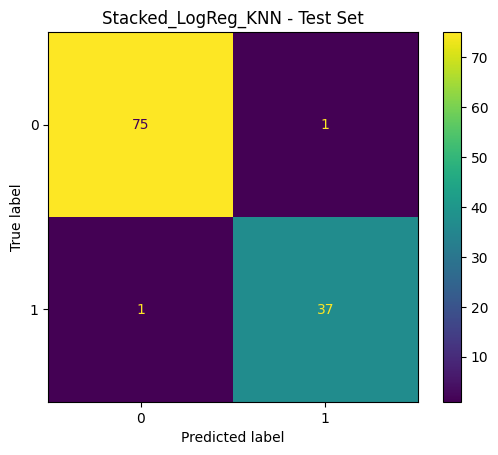

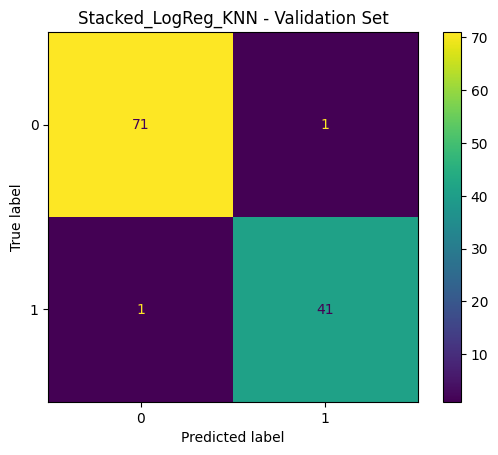

Cross Validation Scores: [0.97101449 0.95588235 0.97058824 0.95588235 0.95588235]
Average CV Score: 0.9618499573742542
Processing Stacked_LogReg_KNN_PCA

--- Stacked_LogReg_KNN_PCA ---

 Evaluation - Test Set
Accuracy : 0.9386
Precision: 0.9438
Recall   : 0.9386
F1 Score : 0.9368

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        76
           1       1.00      0.82      0.90        38

    accuracy                           0.94       114
   macro avg       0.96      0.91      0.93       114
weighted avg       0.94      0.94      0.94       114

ROC AUC Score: 0.9796


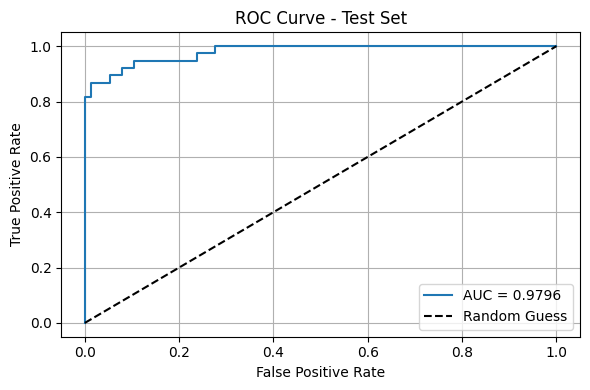

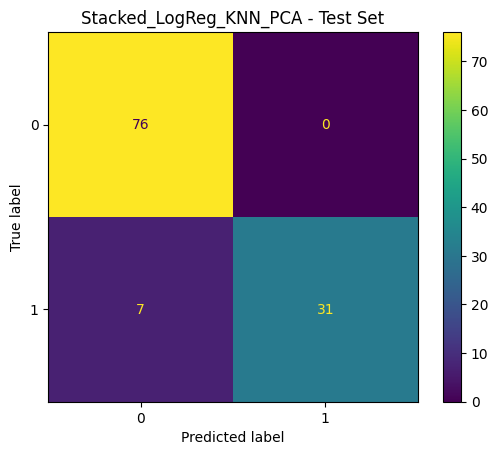

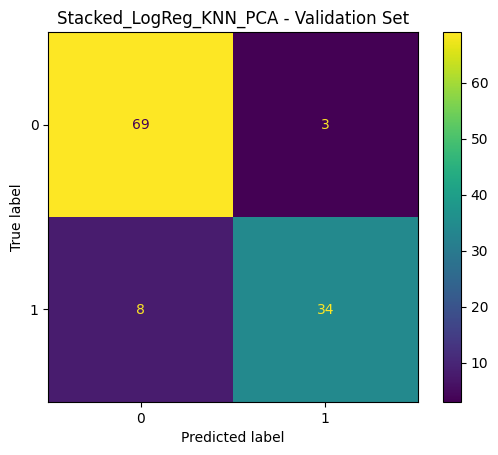

Cross Validation Scores: [0.84057971 0.83823529 0.82352941 0.85294118 0.85294118]
Average CV Score: 0.8416453537936913


In [ ]:
# Group models by base name (strip _PCA if present)
base_models = {}
for name, model in best_models.items():
    base_name = name.replace("_PCA", "")
    if base_name not in base_models:
        base_models[base_name] = {}
    if "PCA" in name:
        base_models[base_name]["pca"] = (name, model)
    else:
        base_models[base_name]["normal"] = (name, model)

# Iterate base models and print normal + PCA sequentially
for base_name, variants in base_models.items():
    for variant_type in ["normal", "pca"]:  # normal first, then PCA
        if variant_type in variants:
            name, model = variants[variant_type]

            print("=" * 40)
            print(f"Processing {name}")
            print("=" * 40)

            # Choose inputs
            if "PCA" in name:
                X_test_input = X_test_pca
                X_val_input = X_val_pca
                X_train_input = X_train_pca
            else:
                X_test_input = X_test
                X_val_input = X_val
                X_train_input = X_train

            # Predictions
            y_test_pred = model.predict(X_test_input)
            y_val_pred = model.predict(X_val_input)

            # Evaluate
            print(f"\n--- {name} ---")
            evaluate_model(y_test, y_test_pred, True, X_test_input, model, "Test Set")
            plot_confusion_matrix(y_test, y_test_pred, f"{name} - Test Set")
            plot_confusion_matrix(y_val, y_val_pred, f"{name} - Validation Set")

            # Cross-validation
            scores = cross_val_score(model, X_train_input, y_train, cv=5)
            print("Cross Validation Scores:", scores)
            print("Average CV Score:", scores.mean())
